# Examine the new query

In [28]:
%matplotlib notebook

In [124]:
# imports
from matplotlib import pyplot as plt

from astropy.io import fits
from astropy.table import Table, hstack
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.cosmology import Planck15 as cosmo

sys.path.append(os.path.abspath("./py"))
import tpe_sample as tsmpl
import tpe_stack as tstack

## Load

In [2]:
qso_fg = Table.read('QPQ_v2000_R15_novette.fits',hdu=1)
qso_bg = Table.read('QPQ_v2000_R15_novette.fits',hdu=2)

In [3]:
qso_fg['LOGLV'][0:5]

30.7522770417
30.7522770417
30.7522770417
30.018314518
30.018314518


## TPE

In [88]:
Lcut = 31.5

In [89]:
reload(tsmpl)
tpe = tsmpl.make_tpe(Lcut, qso_fg=qso_fg, qso_bg=qso_bg)

8748 pairs satisfy the Lcut of 31.5
Database is igmspec
Created on 2017-Jan-05
Database is QPQ
Created on 2017-Jan-02
Your search yielded 5280 matches from 8748 input coordinates
Your search yielded 109 matches from 8748 input coordinates
Your search yielded 3371 matches from 8748 input coordinates
Your search yielded 38 matches from 8748 input coordinates
3386 f/g quasars in IgmSpec or QPQspec
5293 b/g quasars in IgmSpec or QPQspec
2579 quasar pairs where both has a spec)
Generating TPE table from those with a good b/g spec


In [90]:
tpe[0:3]

FG_Z,FG_LOGLV,FG_RA,FG_DEC,FG_IGM_ID,FG_QPQ_ID,FG_MYERS_ZEM_SOURCE,BG_Z,BG_RA,BG_DEC,BG_IGM_ID,BG_QPQ_ID
float64,float64,float64,float64,int64,int64,str8,float64,float64,float64,int64,int64
1.86253488064,38.3132521513,239.46599,34.879942,-1,-1,,1.94299995899,239.54349,34.882073,251046,-1
1.86253488064,38.3132521513,239.46599,34.879942,-1,-1,,2.17480993271,239.48099,35.046847,250975,-1
1.73182809353,38.2410137879,354.2772,-0.196396,-1,-1,,1.92264604568,354.22716,-0.060040125,381678,-1


## Deal with Junk

In [91]:
c_fg = SkyCoord(ra=tpe['FG_RA'], dec=tpe['FG_DEC'], unit='deg')
c_bg = SkyCoord(ra=tpe['BG_RA'], dec=tpe['BG_DEC'], unit='deg')

In [92]:
sep = c_fg.separation(c_bg)

In [93]:
close = sep < 5*u.arcsec   # There are several ok ones at 7"
np.sum(close)

13

In [94]:
tpe[close]

FG_Z,FG_LOGLV,FG_RA,FG_DEC,FG_IGM_ID,FG_QPQ_ID,FG_MYERS_ZEM_SOURCE,BG_Z,BG_RA,BG_DEC,BG_IGM_ID,BG_QPQ_ID
float64,float64,float64,float64,int64,int64,str8,float64,float64,float64,int64,int64
2.53999996185,38.5291849663,168.970413208,13.8102779388,-1,-1,VCV,2.57982563972,168.97039,13.81102,131518,-1
2.00500011444,38.3161192618,243.190002441,23.9666671753,-1,-1,VCV,2.0469019413,243.18916,23.966674,372552,-1
2.17000007629,38.379322215,149.287506104,48.26222229,-1,-1,VCV,2.19604992867,149.287,48.262839,94033,-1
4.23999977112,38.9344996013,219.648330688,25.6424999237,-1,-1,VCV,4.28182697296,219.64795,25.641865,222707,-1
2.29999995232,38.4330590065,23.5020828247,31.3024997711,-1,-1,VCV,2.35825538635,23.501534,31.302814,24360,-1
2.15000009537,38.3654341863,217.681243896,53.7541656494,-1,-1,VCV,2.17363786697,217.6816,53.754752,219476,-1
1.85000002384,38.307027668,32.0125007629,-5.04944467545,-1,-1,VCV,1.87300002575,32.012678,-5.0500032,32212,-1
1.84500002861,38.3043834948,166.649169922,8.73361110687,-1,-1,VCV,1.86519098282,166.649383545,8.73397827148,127336,-1
3.2539999485,31.606884433,229.691665649,48.3791656494,-1,-1,VCV,3.28721094131,229.692062378,48.3793678284,237726,-1


### Spot check one or two with Simbad
    230.78059387d53.899505615  -- Only one source within 1 arcmin

### I think we can cut on f/g from VCV

In [95]:
junk = (sep < 5*u.arcsec) & (tpe['FG_MYERS_ZEM_SOURCE'] == 'VCV')

In [96]:
cut_tpe=tpe[~junk]

## Meta spec table

In [97]:
reload(tstack)
spec_tbl = tstack.get_spec_meta(cut_tpe)

Database is igmspec
Created on 2017-Jan-05
Database is QPQ
Created on 2017-Jan-02
Your search yielded 5267 matches from 5280 input coordinates
Your search yielded 108 matches from 5280 input coordinates
Looping on pairs
Instr = mmtbluechan not in Priority dict with disperser=800GPM
Instr = mmtbluechan not in Priority dict with disperser=800GPM
Instr = MODS1B not in Priority dict with disperser=G400L


### There is likely junk in the South with 2dF
    I think these will get culled by an upper bound on LogLV

In [98]:
spec_tbl[0:3]

specm,best_spec,nok,ibest,best_row,nspec,DBASE,GROUP,GROUP_ID,SPEC_FILE
unicode182,unicode27,int64,int64,int64,int64,unicode7,unicode10,int64,unicode86
,,0,-1,-1,0,none,none,-1,N/A
,,0,-1,-1,0,none,none,-1,N/A
,,0,-1,-1,0,none,none,-1,N/A


In [99]:
gd_spec = spec_tbl['nok'] > 0

In [100]:
spec_tpe = cut_tpe[gd_spec]
spec_tpe

FG_Z,FG_LOGLV,FG_RA,FG_DEC,FG_IGM_ID,FG_QPQ_ID,FG_MYERS_ZEM_SOURCE,BG_Z,BG_RA,BG_DEC,BG_IGM_ID,BG_QPQ_ID
float64,float64,float64,float64,int64,int64,str8,float64,float64,float64,int64,int64
2.14969205856,31.657671229,235.872802734,33.9857521057,246288,-1,SDSS-HW,2.34400010109,235.91634,33.933099,246347,-1
3.09072995186,31.754088972,233.00669,37.000662,242296,-1,SDSS-HW,3.15195798874,232.87015,36.958381,242099,-1
2.0631082058,31.5179284053,258.2289,35.987412,-1,-1,,2.38838171959,258.23173,36.070178,266284,-1
2.0631082058,31.5179284053,258.2289,35.987412,-1,-1,,2.18700003624,258.11884,36.114498,266242,-1
2.04311800003,38.3154890183,326.1232,0.61066119,-1,-1,,2.52967905998,326.16392,0.6024202,270812,2241
2.04311800003,38.3154890183,326.1232,0.61066119,-1,-1,,2.53299999237,326.16392,0.6024202,270812,2241
2.09999990463,38.3357536999,261.449584961,34.3705558777,-1,-1,VCV,2.16199994087,261.37245,34.441449,267259,-1
2.09999990463,38.3357536999,261.449584961,34.3705558777,-1,-1,VCV,2.52939963341,261.54735,34.420787,267289,-1
2.53133010864,31.6257508656,246.45332,26.782996,258556,2152,SDSS-HW,2.60573792458,246.4891,26.746716,258582,736


## Stats

### $L_V$

In [101]:
cut_LV = spec_tpe['FG_LOGLV'] < 37.
LV_tpe = spec_tpe[cut_LV]
len(LV_tpe)

182

<IPython.core.display.Javascript object>


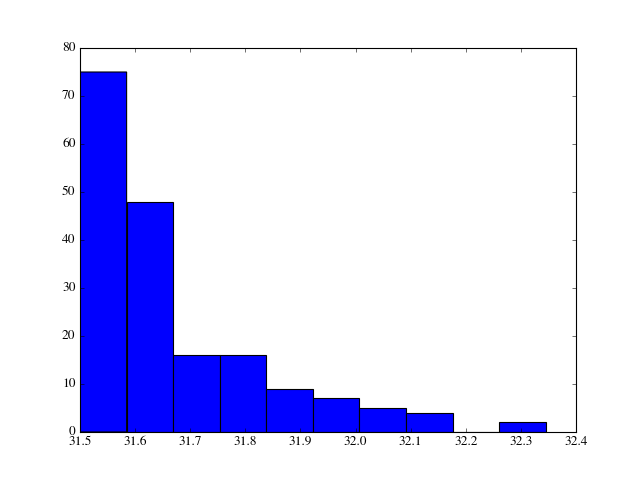

In [102]:
plt.clf()
ax = plt.gca()
ax.hist(LV_tpe['FG_LOGLV'])
plt.show()

### R

In [104]:
b_coords = SkyCoord(ra=LV_tpe['BG_RA'], dec=LV_tpe['BG_DEC'], unit='deg')
f_coords = SkyCoord(ra=LV_tpe['FG_RA'], dec=LV_tpe['FG_DEC'], unit='deg')
kpc_amin = cosmo.kpc_comoving_per_arcmin(LV_tpe['FG_Z'])  # kpc per arcmin
ang_seps = b_coords.separation(f_coords)
rho_new = ang_seps.to('arcmin') * kpc_amin / (1+LV_tpe['FG_Z']) # Physical

<IPython.core.display.Javascript object>


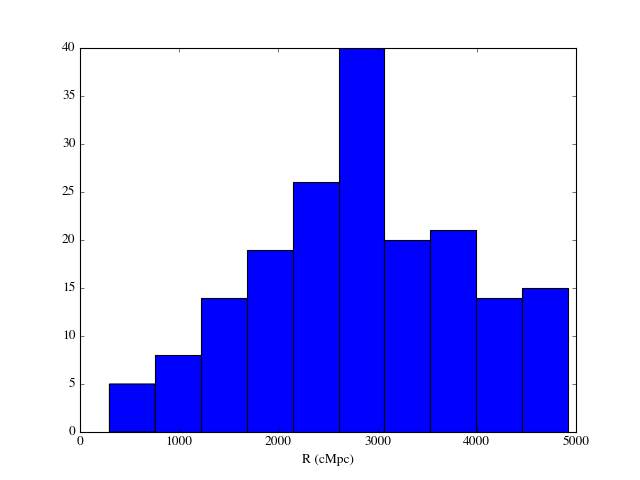

In [105]:
plt.clf()
ax = plt.gca()
ax.hist(rho_new)
ax.set_xlabel('R (cMpc)')
plt.show()

In [106]:
final_cut = rho_new < 4*u.Mpc # physical
np.sum(final_cut)

155

In [107]:
final_tpe = LV_tpe[final_cut]
final_tpe

FG_Z,FG_LOGLV,FG_RA,FG_DEC,FG_IGM_ID,FG_QPQ_ID,FG_MYERS_ZEM_SOURCE,BG_Z,BG_RA,BG_DEC,BG_IGM_ID,BG_QPQ_ID
float64,float64,float64,float64,int64,int64,str8,float64,float64,float64,int64,int64
2.14969205856,31.657671229,235.872802734,33.9857521057,246288,-1,SDSS-HW,2.34400010109,235.91634,33.933099,246347,-1
3.09072995186,31.754088972,233.00669,37.000662,242296,-1,SDSS-HW,3.15195798874,232.87015,36.958381,242099,-1
2.0631082058,31.5179284053,258.2289,35.987412,-1,-1,,2.38838171959,258.23173,36.070178,266284,-1
2.53133010864,31.6257508656,246.45332,26.782996,258556,2152,SDSS-HW,2.60573792458,246.4891,26.746716,258582,736
2.53133010864,31.6257508656,246.45332,26.782996,258556,2152,SDSS-HW,2.60700011253,246.4891,26.746716,258582,736
2.23000001907,31.592840438,132.692382812,52.3493499756,65841,-1,BOSS_PCA,2.80999994278,132.68481,52.270394,65826,-1
2.60400009155,31.5372956422,131.12411,52.718485,63142,-1,BOSS_PCA,3.02912950516,131.09609,52.655698,63092,-1
2.13831806183,31.5396357292,131.41109,34.345449,63629,-1,SDSS-HW,2.41815805435,131.37653,34.229122,63563,-1
2.13831806183,31.5396357292,131.41109,34.345449,63629,-1,SDSS-HW,2.31306004524,131.34124,34.276298,63510,-1


## Check against old TPE

In [108]:
old_312 = Table.read('TPE_DR12_31.2_spec.fits')

In [109]:
b_coords = SkyCoord(ra=old_312['BG_RA'], dec=old_312['BG_DEC'], unit='deg')
f_coords = SkyCoord(ra=old_312['FG_RA'], dec=old_312['FG_DEC'], unit='deg')
kpc_amin = cosmo.kpc_comoving_per_arcmin(old_312['FG_Z'])  # kpc per arcmin
ang_seps = b_coords.separation(f_coords)
rho = ang_seps.to('arcmin') * kpc_amin  # comoving

In [110]:
cut_old = rho < 4*u.Mpc # comoving
cut_312 = old_312[cut_old]
cut_312

FG_Z,FG_LOGLV,FG_G_UV,FG_RA,FG_DEC,BG_Z,BG_RA,BG_DEC,BG_LYA_INSTRUMENT,BG_LYA_FILE
float64,float32,float64,float64,float64,float64,float64,float64,str8,str39
2.4849998951,31.5575,1115.08614949,17.9586150746,14.0281577616,2.93550395966,17.9558203147,14.0377133359,LRIS,SDSSJ011149.40+140215.8_b1200_F.fits.gz
3.16700005531,31.4852,831.522317098,24.1232678295,15.0480795383,3.38800001144,24.1307876106,15.0384509056,LRIS,SDSSJ013631.39+150218.4_b400_F.fits.gz
2.12019991875,31.4614,402.793233588,175.480992282,53.2188131441,2.21753907204,175.487077905,53.232746766,LRIS,SDSSJ114156.88+531358.1_b1200_F.fits.gz
3.23960494995,31.3928,128.520587899,184.833240694,20.8201374387,3.30232191086,184.861217872,20.8100352711,BOSS,SDSSJ121926.69+204836.1.fits
2.40697693825,31.4277,70.3259723466,194.892884755,7.86686178365,2.73218297958,194.863196393,7.88347779013,BOSS,SDSSJ125927.17+075300.5.fits
1.73456704617,31.3287,2145.93843303,221.122497067,31.2225650079,1.79499995708,221.11651431,31.2205412644,LRIS,SDSSJ144427.97+311313.8_b1200_F.fits.gz
2.56533193588,31.2218,39.2516575125,238.776705163,36.8989334706,2.99117398262,238.748773913,36.8701924469,BOSS,SDSSJ155459.70+365212.7.fits
2.49014496803,31.2254,79.5163590278,248.733981074,30.2438399897,2.93283104897,248.750273771,30.2227065829,ESI,SDSSJ163500.06+301321.7_F.fits.gz
2.25060009956,31.2726,36.0255833933,333.071995474,0.540825220745,2.46805906296,333.110047127,0.548692504361,BOSS,SDSSJ221226.41+003255.3.fits


In [111]:
old_coord = SkyCoord(ra=cut_312['FG_RA'], dec=cut_312['FG_DEC'], unit='deg')
new_coord = SkyCoord(ra=final_tpe['FG_RA'], dec=final_tpe['FG_DEC'], unit='deg')

In [112]:
idx, d2d, d3d = match_coordinates_sky(old_coord, new_coord, nthneighbor=1)
no_match = d2d > 2*u.arcsec
np.sum(no_match)

9

### Check LV

In [113]:
cut_312['FG_LOGLV'][0], final_tpe['FG_LOGLV'][idx[0]]

(31.557503, 31.536296422945938)

### VCV

In [114]:
vcv = final_tpe['FG_MYERS_ZEM_SOURCE'] == 'VCV'
np.sum(vcv)

41

In [119]:
no_fg = np.all([final_tpe['FG_IGM_ID'] < 0, final_tpe['FG_QPQ_ID'] < 0],axis=0)
np.sum(no_fg)

37

#### Checking a few
    24.435277d11.672611  -- Fine (HES;  z may be poor)

### Null (i.e. QPQ source)

In [123]:
qpq_z = (final_tpe['FG_MYERS_ZEM_SOURCE'] == '') & (final_tpe['FG_IGM_ID'] < 0) & (final_tpe['FG_QPQ_ID'] < 0)
np.sum(qpq_z)

14